# Neurosynth ML Decoding
The goal is to do reverse inference **(Brain Activation Pattern→Terms)** using machine learning. 

Ideally, a trained machine learner, **F**, should output terms strongly associated with a brain activation pattern. 

For example, given the activation of the left amygdala @ [x,y,z]=[-22,0,-20], F([-22,0,-20]) will output/indicate **"amygdala", "fear", etc**.

## 0. Loading Neurosynth Dataset

In [47]:
from nimare import dataset as nimare_dataset
import os

PICKLE_PATH = "neurosynth_dataset.pkl.gz"
dset = nimare_dataset.Dataset.load(PICKLE_PATH)
print("n_studies =", len(dset.ids))
print("shapes: coords", dset.coordinates.shape, "meta", dset.metadata.shape, "ann", dset.annotations.shape)

n_studies = 14371
shapes: coords (507891, 7) meta (14371, 7) ann (14371, 3231)


In [3]:
# Not needed for this example
dset.metadata

id  study_id contrast_id  \
0      10022492-1  10022492           1   
1      10022494-1  10022494           1   
2      10022496-1  10022496           1   
3      10051677-1  10051677           1   
4      10191322-1  10191322           1   
...           ...       ...         ...   
14366   9819274-1   9819274           1   
14367   9838166-1   9838166           1   
14368   9862924-1   9862924           1   
14369   9886448-1   9886448           1   
14370   9990082-1   9990082           1   

                                                 authors  \
0      Callicott JH, Mattay VS, Bertolino A, Finn K, ...   
1      Toni I, Schluter ND, Josephs O, Friston K, Pas...   
2      Lockwood AH, Salvi RJ, Coad ML, Arnold SA, Wac...   
3      Denton D, Shade R, Zamarippa F, Egan G, Blair-...   
4                               Chee MW, Tan EW, Thiel T   
...                                                  ...   
14366  Lobel E, Kleine JF, Bihan DL, Leroy-Willig A, ...   
14367  Wildgruber D, Kischka U, Ackermann H, Klose U,...   
14368     Porro CA, Cettolo V, Francescato MP, Baraldi P   
14369  Van Der Werf YD, Weerts JG, Jolles J, Witter M...   
14370                                   Lumer ED, Rees G   

                                                 journal  year  \
0                Cerebral cortex (New York, N.Y. : 1991)  1999   
1                Cerebral cortex (New York, N.Y. : 1991)  1999   
2                Cerebral cortex (New York, N.Y. : 1991)  1999   
3      Proceedings of the National Academy of Science...  1999   
4      The Journal of neuroscience : the official jou...  1999   
...                                                  ...   ...   
14366                         Journal of neurophysiology  1998   
14367           Brain research. Cognitive brain research  1999   
14368                         Journal of neurophysiology  1998   
14369  Journal of neurology, neurosurgery, and psychi...  1999   
14370  Proceedings of the National Academy of Science...  1999   

                                                   title  
0      Physiological characteristics of capacity cons...  
1      Signal-, set- and movement-related activity in...  
2      The functional anatomy of the normal human aud...  
3      Correlation of regional cerebral blood flow an...  
4      Mandarin and English single word processing st...  
...                                                  ...  
14366  Functional MRI of galvanic vestibular stimulat...  
14367  Dynamic pattern of brain activation during seq...  
14368  Temporal and intensity coding of pain in human...  
14369  Neuropsychological correlates of a right unila...  
14370  Covariation of activity in visual and prefront...  

[14371 rows x 7 columns]

1. EDA

=== 資料集基本資訊 ===
n_studies = 14371
座標形狀: (507891, 7)
元數據形狀: (14371, 7)
註釋形狀: (14371, 3230)

=== 1. 研究數量分析 ===
總研究數: 14371
座標點數: 507891
元數據記錄數: 14371
註釋記錄數: 14371

=== 2. metadata探索 ===
元數據欄位: ['id', 'study_id', 'contrast_id', 'authors', 'journal', 'year', 'title']

元數據前5行:
           id  study_id contrast_id  \
0  10022492-1  10022492           1   
1  10022494-1  10022494           1   
2  10022496-1  10022496           1   
3  10051677-1  10051677           1   
4  10191322-1  10191322           1   

                                             authors  \
0  Callicott JH, Mattay VS, Bertolino A, Finn K, ...   
1  Toni I, Schluter ND, Josephs O, Friston K, Pas...   
2  Lockwood AH, Salvi RJ, Coad ML, Arnold SA, Wac...   
3  Denton D, Shade R, Zamarippa F, Egan G, Blair-...   
4                           Chee MW, Tan EW, Thiel T   

                                             journal  year  \
0            Cerebral cortex (New York, N.Y. : 1991)  1999   
1            Cerebral cortex (N

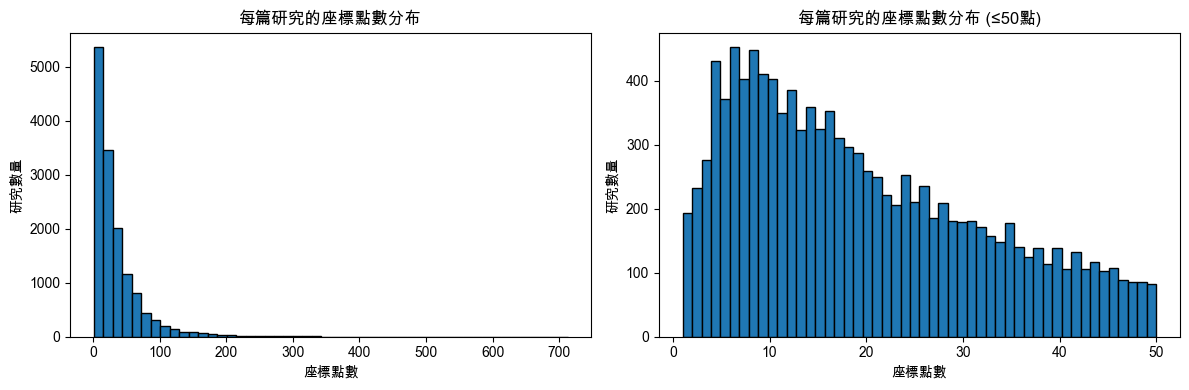


=== 5. 座標空間分布視覺化 ===


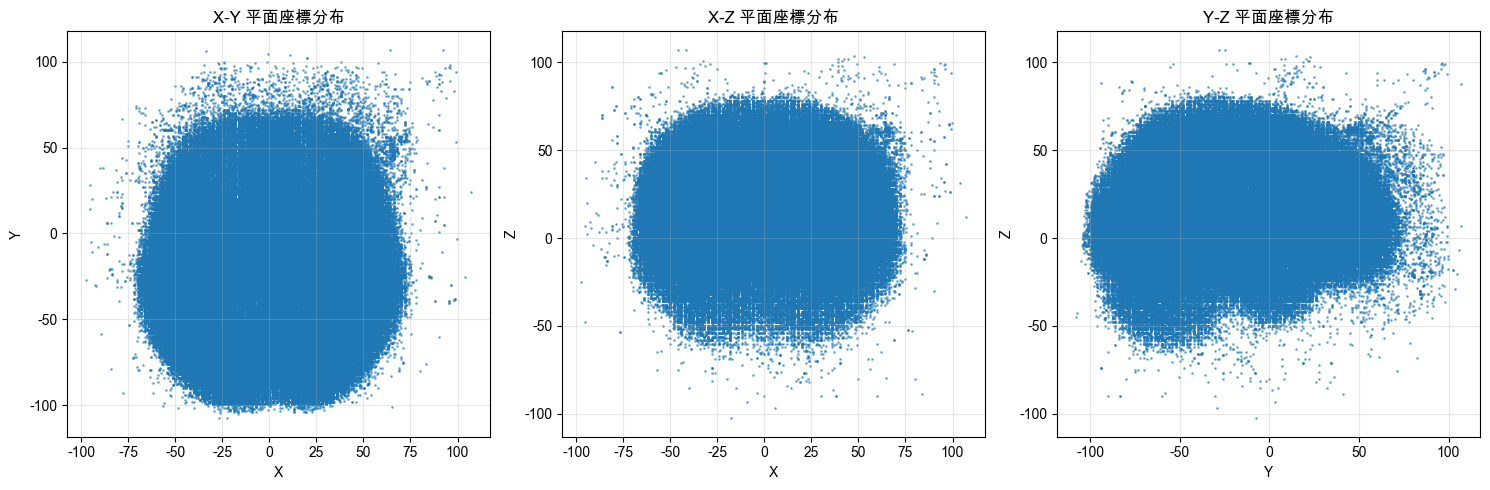


=== 6. 時間分布分析 ===
年份分布:
year
1997      7
1998     16
1999     48
2000     86
2001    110
2002    163
2003    356
2004    372
2005    509
2006    628
Name: count, dtype: int64


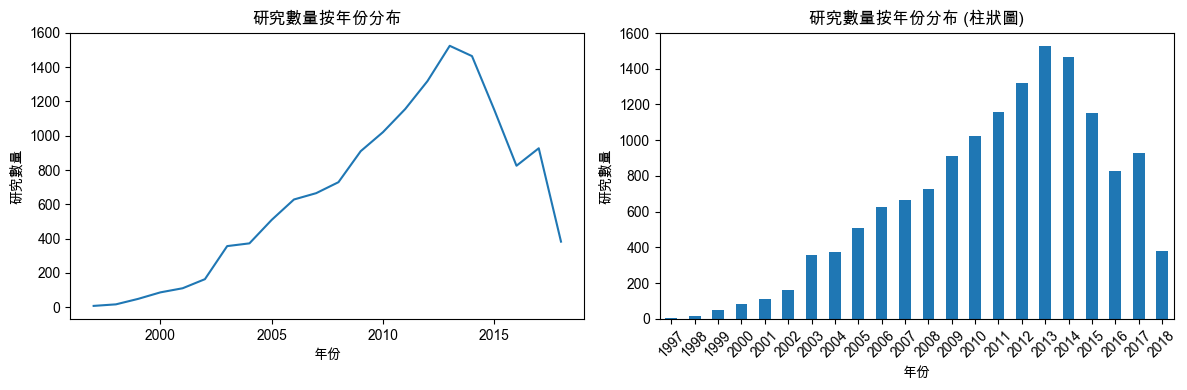


=== 7. annotations資料探索 ===
annotations欄位數量: 3230
前10個annotations欄位: ['id', 'contrast_id', 'terms_abstract_tfidf__001', 'terms_abstract_tfidf__01', 'terms_abstract_tfidf__05', 'terms_abstract_tfidf__10', 'terms_abstract_tfidf__100', 'terms_abstract_tfidf__11', 'terms_abstract_tfidf__12', 'terms_abstract_tfidf__12 healthy']
annotations資料密度: 0.023

前20個annotations的出現頻率:
contrast_id                                  14371
terms_abstract_tfidf__magnetic                6705
terms_abstract_tfidf__resonance               6608
terms_abstract_tfidf__magnetic resonance      6577
terms_abstract_tfidf__functional magnetic     6038
terms_abstract_tfidf__task                    5993
terms_abstract_tfidf__using                   5703
terms_abstract_tfidf__frontal                 4735
terms_abstract_tfidf__temporal                4526
terms_abstract_tfidf__suggest                 4471
terms_abstract_tfidf__prefrontal              4400
terms_abstract_tfidf__healthy                 4284
terms_abstract_tf

In [86]:
# 設定中文字體 - 多種方法嘗試
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 如果上面的方法不行，可以嘗試設定字體路徑（Windows）
try:
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
except:
    pass

print("=== 資料集基本資訊 ===")
print("n_studies =", len(dset.ids))
print("座標形狀:", dset.coordinates.shape)
print("元數據形狀:", dset.metadata.shape) 
print("註釋形狀:", dset.annotations.shape)

print("\n=== 1. 研究數量分析 ===")
print(f"總研究數: {len(dset.ids)}")
print(f"座標點數: {len(dset.coordinates)}")
print(f"元數據記錄數: {len(dset.metadata)}")
print(f"註釋記錄數: {len(dset.annotations)}")

print("\n=== 2. metadata探索 ===")
print("元數據欄位:", dset.metadata.columns.tolist())
print("\n元數據前5行:")
print(dset.metadata.head())

print("\n=== 3. coordinates探索 ===")
print("座標欄位:", dset.coordinates.columns.tolist())
print("\n座標資料前5行:")
print(dset.coordinates.head())

print("\ncoordinates統計資訊:")
print(dset.coordinates[['x', 'y', 'z']].describe())

# 檢查座標範圍
print(f"\nX座標範圍: {dset.coordinates['x'].min():.2f} ~ {dset.coordinates['x'].max():.2f}")
print(f"Y座標範圍: {dset.coordinates['y'].min():.2f} ~ {dset.coordinates['y'].max():.2f}")
print(f"Z座標範圍: {dset.coordinates['z'].min():.2f} ~ {dset.coordinates['z'].max():.2f}")

print("\n=== 4. 每篇研究的座標點數分析 ===")
coords_per_study = dset.coordinates.groupby('id').size()
print(f"每篇研究平均座標點數: {coords_per_study.mean():.2f}")
print(f"每篇研究最少座標點數: {coords_per_study.min()}")
print(f"每篇研究最多座標點數: {coords_per_study.max()}")
print(f"座標點數中位數: {coords_per_study.median()}")

# 繪製每篇研究的座標點數分布
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(coords_per_study, bins=50, edgecolor='black')
plt.title('每篇研究的座標點數分布')
plt.xlabel('座標點數')
plt.ylabel('研究數量')

plt.subplot(1, 2, 2)
plt.hist(coords_per_study[coords_per_study <= 50], bins=50, edgecolor='black')
plt.title('每篇研究的座標點數分布 (≤50點)')
plt.xlabel('座標點數')
plt.ylabel('研究數量')
plt.tight_layout()
plt.show()

print("\n=== 5. 座標空間分布視覺化 ===")
fig = plt.figure(figsize=(15, 5))

# X-Y 平面
plt.subplot(1, 3, 1)
plt.scatter(dset.coordinates['x'], dset.coordinates['y'], alpha=0.5, s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X-Y 平面座標分布')
plt.grid(True, alpha=0.3)

# X-Z 平面
plt.subplot(1, 3, 2)
plt.scatter(dset.coordinates['x'], dset.coordinates['z'], alpha=0.5, s=1)
plt.xlabel('X')
plt.ylabel('Z')
plt.title('X-Z 平面座標分布')
plt.grid(True, alpha=0.3)

# Y-Z 平面
plt.subplot(1, 3, 3)
plt.scatter(dset.coordinates['y'], dset.coordinates['z'], alpha=0.5, s=1)
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Y-Z 平面座標分布')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== 6. 時間分布分析 ===")
if 'year' in dset.metadata.columns:
    print("年份分布:")
    year_counts = dset.metadata['year'].value_counts().sort_index()
    print(year_counts.head(10))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    year_counts.plot(kind='line')
    plt.title('研究數量按年份分布')
    plt.xlabel('年份')
    plt.ylabel('研究數量')
    
    plt.subplot(1, 2, 2)
    year_counts.plot(kind='bar')
    plt.title('研究數量按年份分布 (柱狀圖)')
    plt.xlabel('年份')
    plt.ylabel('研究數量')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("\n=== 7. annotations資料探索 ===")
print("annotations欄位數量:", dset.annotations.shape[1])
print("前10個annotations欄位:", dset.annotations.columns[:10].tolist())

# 檢查annotations的稀疏性
annotation_density = (dset.annotations.iloc[:, 1:] != 0).mean().mean()
print(f"annotations資料密度: {annotation_density:.3f}")

# 顯示前幾個annotations的統計
print("\n前20個annotations的出現頻率:")
top_annotations = (dset.annotations.iloc[:, 1:] != 0).sum().sort_values(ascending=False)[:20]
print(top_annotations)

print("\n=== 8. 缺失值檢查 ===")
print("coordinates資料缺失值:")
print(dset.coordinates.isnull().sum())

print("\nmetadata缺失值:")
print(dset.metadata.isnull().sum())



print("\n=== 9. 資料品質摘要 ===")
print(f"總座標點數: {len(dset.coordinates)}")
print(f"總研究數: {len(dset.ids)}")
print(f"平均每個研究的座標點數: {len(dset.coordinates)/len(dset.ids):.2f}")
print(f"座標空間範圍: X({dset.coordinates['x'].min():.1f}~{dset.coordinates['x'].max():.1f}), "
      f"Y({dset.coordinates['y'].min():.1f}~{dset.coordinates['y'].max():.1f}), "
      f"Z({dset.coordinates['z'].min():.1f}~{dset.coordinates['z'].max():.1f})")

# 檢查是否有重複座標
duplicate_coords = dset.coordinates.duplicated(subset=['x', 'y', 'z']).sum()
print(f"重複座標數量: {duplicate_coords}")

print("\n=== 分析完成 ===")

## 1. Brain Activation Clusters
Apply an unsupervised learning algorithm to cluster 507,891 coordinates into M clusters. The optimal value of M can be determined using the Elbow method or other appropriate techniques.

Save the following results:

[1] The cluster assignment (category membership) for each of the 507,891 coordinates.

[2] The coordinates of each cluster center (prototype).

In [5]:
dset.coordinates

id  study_id contrast_id     x     y     z       space
1483  10022492-1  10022492           1  36.0 -58.0  52.0  mni152_2mm
1499  10022492-1  10022492           1  48.0  24.0  20.0  mni152_2mm
1498  10022492-1  10022492           1 -42.0  26.0  20.0  mni152_2mm
1497  10022492-1  10022492           1 -36.0  30.0  16.0  mni152_2mm
1496  10022492-1  10022492           1 -30.0  32.0   0.0  mni152_2mm
...          ...       ...         ...   ...   ...   ...         ...
1479   9990082-1   9990082           1  42.0 -54.0 -21.0  mni152_2mm
1480   9990082-1   9990082           1 -36.0 -87.0  -6.0  mni152_2mm
1481   9990082-1   9990082           1  30.0 -81.0 -15.0  mni152_2mm
1467   9990082-1   9990082           1 -18.0 -60.0  54.0  mni152_2mm
1482   9990082-1   9990082           1 -21.0 -78.0  27.0  mni152_2mm

[507891 rows x 7 columns]

In [7]:
# 移除 dset.coordinates 中的空值
clean_coords = dset.coordinates.dropna().reset_index(drop=True)

# 檢查結果
print("Cleaned coordinates shape:", clean_coords.shape)
print(clean_coords.head())

Cleaned coordinates shape: (507891, 7)
           id  study_id contrast_id     x     y     z       space
0  10022492-1  10022492           1  36.0 -58.0  52.0  mni152_2mm
1  10022492-1  10022492           1  48.0  24.0  20.0  mni152_2mm
2  10022492-1  10022492           1 -42.0  26.0  20.0  mni152_2mm
3  10022492-1  10022492           1 -36.0  30.0  16.0  mni152_2mm
4  10022492-1  10022492           1 -30.0  32.0   0.0  mni152_2mm


### kmeans choose K Elbow Method

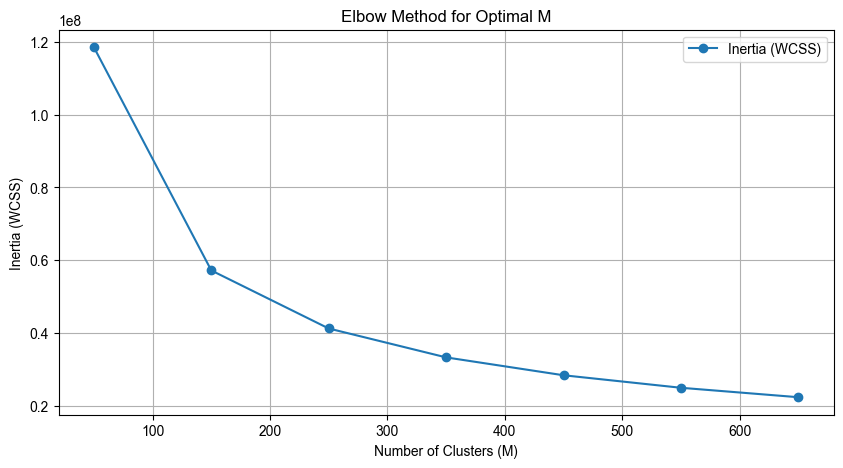

In [8]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假設 clean_coords 已經清理完成，包含 'x', 'y', 'z' 三個座標
valuescoords = clean_coords[['x', 'y', 'z']].values  # 提取座標資料

# Step 1: 使用 Elbow Method 確定最佳叢集數量
random_state = 0
M_range = range(50, 750, 100)  # 測試叢集數量範圍 (50 到 800，每次增加 50)

inertia_values = []  # 儲存每個 M 的 Inertia 值

# 計算不同叢集數量的 Inertia
for M in M_range:
    kmeans = KMeans(n_clusters=M, random_state=random_state)
    kmeans.fit(valuescoords)
    inertia_values.append(kmeans.inertia_)

# 繪製 Elbow Method 圖表
plt.figure(figsize=(10, 5))
plt.plot(M_range, inertia_values, marker='o', label='Inertia (WCSS)')
plt.xlabel('Number of Clusters (M)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal M')
plt.grid()
plt.legend()
plt.show()

1. 選擇 K 值=250 以進行 KMeans 聚類

In [9]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假設 clean_coords 已經清理完成，包含 'x', 'y', 'z' 三個座標
valuescoords = clean_coords[['x', 'y', 'z']].values  # 提取座標資料

# 設定叢集數量
optimal_M = 250  # 替換為您想要的叢集數量

# 執行 KMeans 聚類
kmeans = KMeans(n_clusters=optimal_M, random_state=0)
kmeans.fit(valuescoords)

# 獲取聚類結果
coord_labels = kmeans.labels_  # 每個座標的叢集標籤
cluster_centers = kmeans.cluster_centers_  # 每個叢集的中心座標
# 將叢集標籤新增到 clean_coords
clean_coords['cluster_label'] = coord_labels

# 檢查結果
print(clean_coords.head())

# 輸出聚類結果摘要
print(f"最佳叢集數量: {optimal_M}")
print("前 5 個叢集的中心座標:\n", cluster_centers[:5])
unique, counts = np.unique(coord_labels, return_counts=True)
print(f"叢集大小統計 - Min: {counts.min()}, Median: {np.median(counts)}, Max: {counts.max()}")



           id  study_id contrast_id     x     y     z       space  \
0  10022492-1  10022492           1  36.0 -58.0  52.0  mni152_2mm   
1  10022492-1  10022492           1  48.0  24.0  20.0  mni152_2mm   
2  10022492-1  10022492           1 -42.0  26.0  20.0  mni152_2mm   
3  10022492-1  10022492           1 -36.0  30.0  16.0  mni152_2mm   
4  10022492-1  10022492           1 -30.0  32.0   0.0  mni152_2mm   

   cluster_label  
0              9  
1            126  
2            112  
3            112  
4            157  
最佳叢集數量: 250
前 5 個叢集的中心座標:
 [[-23.47065732   0.57842084   3.63848225]
 [ -8.60464408 -37.95755743  45.10306883]
 [ 52.4404589   27.00143303   6.72191346]
 [ 21.58932018 -55.98214019 -22.87678329]
 [-10.4118598   45.02525307  40.91196248]]
叢集大小統計 - Min: 40, Median: 2012.0, Max: 4204


2. 分群視覺化

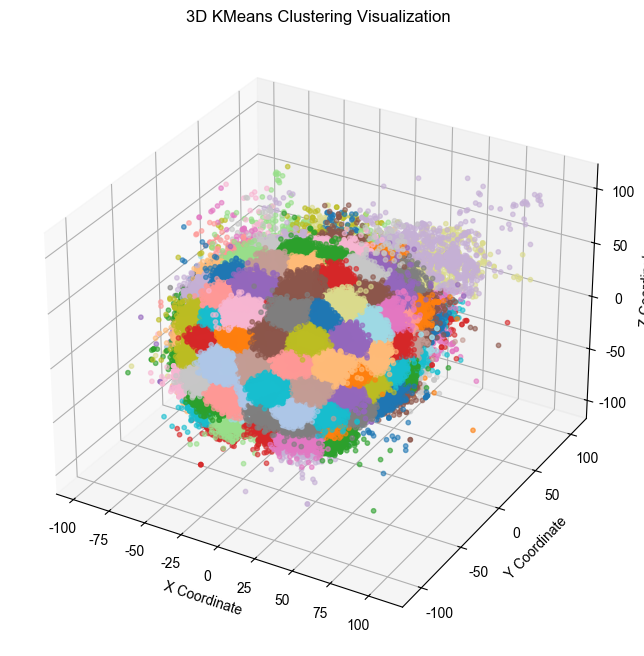

In [10]:
# 3D 視覺化
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 繪製散點圖
scatter = ax.scatter(valuescoords[:, 0], valuescoords[:, 1], valuescoords[:, 2], 
                      c=coord_labels, cmap='tab20', s=10, alpha=0.6)

# 添加軸標籤
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('3D KMeans Clustering Visualization')

plt.show()

3. 儲存檔案

In [11]:
import os
import pandas as pd

# 確保輸出目錄存在
output_dir = 'data_process'
os.makedirs(output_dir, exist_ok=True)

# 儲存叢集中心
cluster_centers_path = os.path.join(output_dir, 'cluster_centers.csv')
pd.DataFrame(cluster_centers, columns=['x', 'y', 'z']).to_csv(cluster_centers_path, index=False)
print(f"[INFO] Cluster centers saved to: {cluster_centers_path}")

# 檢查 clean_coords 和 coord_labels 長度是否一致
if len(clean_coords) != len(coord_labels):
    raise ValueError("[ERROR] Length mismatch: clean_coords 和 coord_labels 長度不一致，請檢查資料處理流程。")

# 儲存每個座標的叢集標籤
coord_labels_path = os.path.join(output_dir, 'coord_cluster_labels.csv')
study_cluster_df = pd.DataFrame({
    'study_id': clean_coords['study_id'].values,
    'x': clean_coords['x'].values,
    'y': clean_coords['y'].values,
    'z': clean_coords['z'].values,
    'cluster_label': coord_labels
})
study_cluster_df.to_csv(coord_labels_path, index=False)
print(f"[INFO] Coordinate cluster labels saved to: {coord_labels_path}")

[INFO] Cluster centers saved to: data_process/cluster_centers.csv


[INFO] Coordinate cluster labels saved to: data_process/coord_cluster_labels.csv


## 2. Characterize Each Study as an M-Dimensional Vector

Use the Bag-of-Visual-Words (BoVW) approach to represent each study as an M-dimensional vector.

In this context, a bag corresponds to a study, and a visual word corresponds to a cluster. The resulting M-dimensional vector is a histogram that records the frequency of each activation cluster within the study.

In [20]:
import numpy as np
import pandas as pd

# 1) 準備座標（與 KMeans fit 時的順序一致）
coordinates = (
    dset.coordinates[['study_id', 'x', 'y', 'z']]
    .dropna()
    .reset_index(drop=True)
)

# 2) 確保 cluster_label 已經正確對應到 coordinates
coordinates['cluster_label'] = study_cluster_df['cluster_label']  # study_cluster_df 必須包含 cluster_label
assert len(coordinates) == len(study_cluster_df), "Length mismatch between coordinates and study_cluster_df."

# 3) 獲取叢集數量 M
M = int(coordinates['cluster_label'].max()) + 1  # 最大 cluster_label + 1

# 4) 依 study_id 分組，計算每篇研究的 BoVW 向量
study_bovw = (
    coordinates.groupby('study_id')['cluster_label']
    .apply(lambda labels: np.bincount(labels, minlength=M))  # 計算每篇研究中每個 cluster 的頻率
)

# 5) 將 BoVW 向量轉換為 DataFrame
bovw_df = pd.DataFrame(
    study_bovw.tolist(),
    index=study_bovw.index,
    columns=[f'cluster_{i}' for i in range(M)]
)

# 6) 輸出 BoVW 矩陣的基本資訊
print("BoVW matrix shape:", bovw_df.shape)  # 矩陣形狀
print("Vector dimension (M):", bovw_df.shape[1])  # 向量維度
print("Non-zero ratio (overall):", (bovw_df != 0).to_numpy().mean())  # 非零比例

# 7) 儲存 BoVW 矩陣到檔案
bovw_df.to_csv("data_process/bovw_matrix.csv", index_label="study_id")
print("BoVW matrix saved to bovw_matrix.csv")

BoVW matrix shape: (14371, 250)
Vector dimension (M): 250
Non-zero ratio (overall): 0.08822322733282305
BoVW matrix saved to bovw_matrix.csv


In [21]:
bovw_df.head()

cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  \
study_id                                                                     
10022492          0          0          0          0          0          0   
10022494          0          0          0          0          0          0   
10022496          0          0          0          0          0          0   
10051677          0          0          0          0          0          0   
10191322          0          0          0          0          0          0   

          cluster_6  cluster_7  cluster_8  cluster_9  ...  cluster_240  \
study_id                                              ...                
10022492          0          0          0          1  ...            0   
10022494          0          0          0          0  ...            0   
10022496          0          0          0          0  ...            0   
10051677          1          0          0          0  ...            0   
10191322          0          0          0          0  ...            0   

          cluster_241  cluster_242  cluster_243  cluster_244  cluster_245  \
study_id                                                                    
10022492            0            0            0            0            0   
10022494            0            0            0            0            0   
10022496            0            0            0            0            0   
10051677            0            0            0            0            0   
10191322            0            0            0            0            0   

          cluster_246  cluster_247  cluster_248  cluster_249  
study_id                                                      
10022492            0            0            0            0  
10022494            0            0            0            0  
10022496            0            0            0            0  
10051677            1            0            0            0  
10191322            0            0            0            0  

[5 rows x 250 columns]

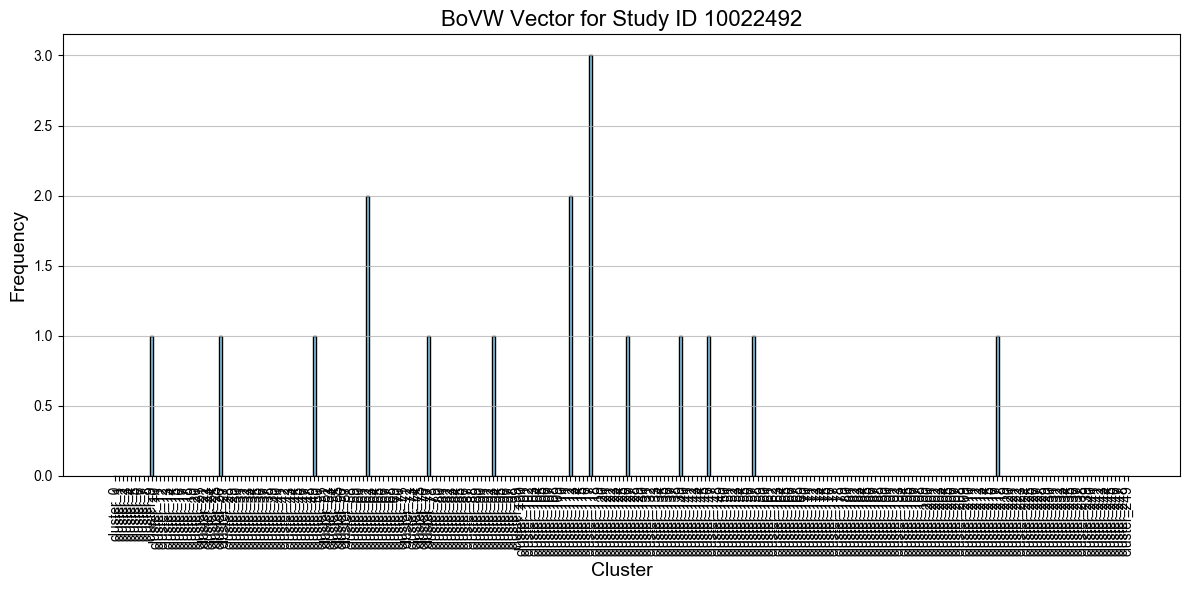

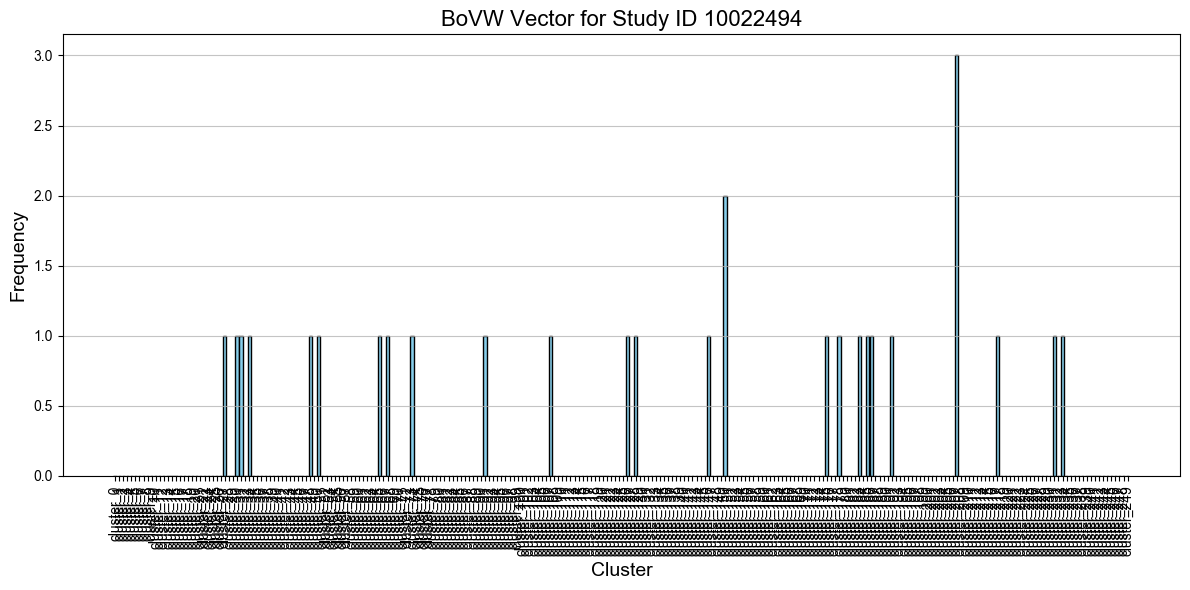

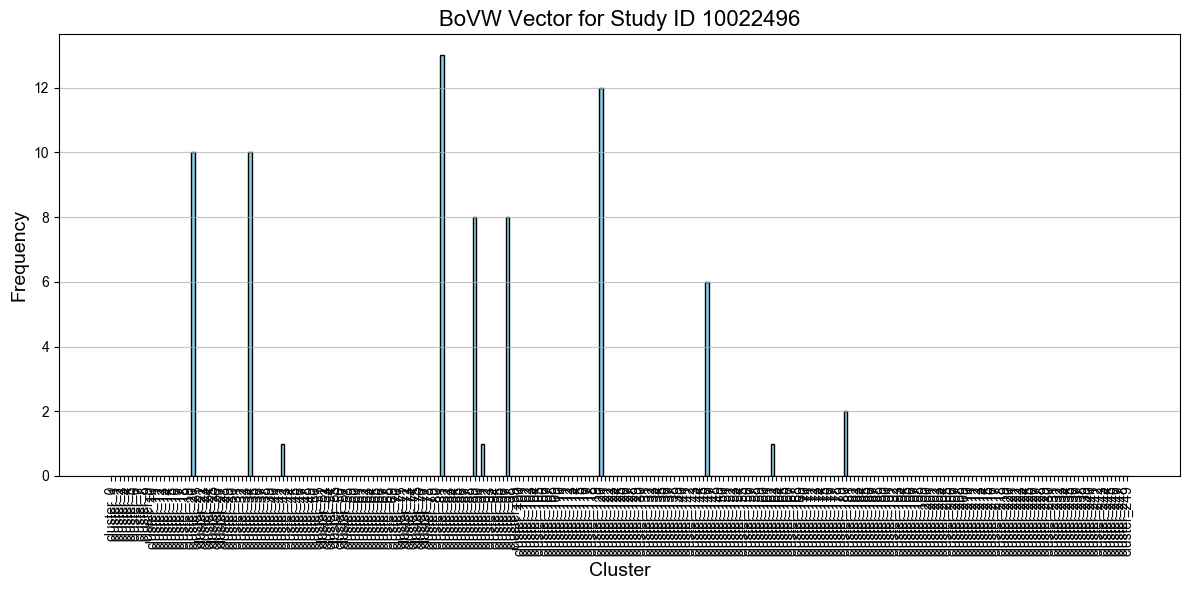

In [14]:
import matplotlib.pyplot as plt

# 選擇要繪製的 study_id
selected_studies = ['10022492', '10022494', '10022496']  # 替換為您感興趣的 study_id

# 繪製每個選定 study_id 的 BoVW 向量
for study_id in selected_studies:
    if study_id not in bovw_df.index:
        print(f"Study ID {study_id} not found in BoVW matrix.")
        continue
    
    # 提取該 study 的 BoVW 向量
    bovw_vector = bovw_df.loc[study_id]
    
    # 繪製直方圖
    plt.figure(figsize=(12, 6))
    plt.bar(bovw_vector.index, bovw_vector.values, color='skyblue', edgecolor='black')
    plt.title(f"BoVW Vector for Study ID {study_id}", fontsize=16)
    plt.xlabel("Cluster", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

## 3. First Approach: kNN Decoding

Convert the left amygdala activation at [x,y,z]=[−22,0,−20] into its M-dimensional representation.

Identify its k nearest neighbors, and compute the average of their associated term vectors from dset.annotations. You can also use "KNeighborsRegressor" in scikit-learn. Report the terms with the highest averaged values (i.e., the winning terms).

1. target 轉換

In [45]:
import numpy as np

# 目標座標
target_coord = np.array([[-22, 0, -20]])  # 注意是二維陣列

# 預測目標座標的叢集標籤
target_cluster_idx = kmeans.predict(target_coord)[0]  # 得到叢集標籤 (0 到 M-1)

# 建立目標點的 BoVW 表示 (假設只有一個點，計數為 1)
target_bow_vector = np.zeros((1, M))  # M 維向量
target_bow_vector[0, target_cluster_idx] = 1  # 只有對應叢集位置為 1

print("Target BoVW vector:", target_bow_vector)
target_bow_df = pd.DataFrame(target_bow_vector, columns=bovw_df.columns)

print("Target BoVW DataFrame:")
print(target_bow_df)

Target BoVW vector: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Target BoVW DataFrame:
   cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  \
0        0.0        0.0        0.0        0.0        0.0        0.0   

   cluster_6  cluster_7  cluster_8  clus

In [48]:
print(dset.annotations.head())
print(bovw_df.head)
dset.annotations.set_index('study_id', inplace=True)

           id  study_id contrast_id  terms_abstract_tfidf__001  \
0  10022492-1  10022492           1                        0.0   
1  10022494-1  10022494           1                        0.0   
2  10022496-1  10022496           1                        0.0   
3  10051677-1  10051677           1                        0.0   
4  10191322-1  10191322           1                        0.0   

   terms_abstract_tfidf__01  terms_abstract_tfidf__05  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   terms_abstract_tfidf__10  terms_abstract_tfidf__100  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0 

- Calculate BoVW Frequencies: Use bovw_df.div(bovw_df.sum(axis=1), axis=0) to normalize the BoVW vector of each study into frequencies (ensuring the sum of frequencies across all clusters equals 1).

- Filter Numeric Term Columns:
Select numerical columns from dset.annotations to generate numeric_annotations, which represent the numerical feature vectors for the terms.

In [76]:
# 確保索引類型一致
bovw_df.index = bovw_df.index.astype(str)
bovw_df_freq = bovw_df.div(bovw_df.sum(axis=1), axis=0)

# 檢查結果

dset.annotations.index = dset.annotations.index.astype(str)

# 篩選數值型列
numeric_annotations = dset.annotations.select_dtypes(include=[np.number])

# 檢查索引是否有交集
common_indices = bovw_df.index.intersection(numeric_annotations.index)
if len(common_indices) == 0:
    raise ValueError("BoVW 矩陣和 annotations 沒有共同的索引，請檢查數據。")

raw_terms_list = numeric_annotations.columns.tolist()

# 定義一個函數來簡化術語名稱
def simplify_term_name(name):
    # 如果名稱包含 "terms_abstract_tfidf__"，則移除前綴
    if name.startswith("terms_abstract_tfidf__"):
        return name[len("terms_abstract_tfidf__"):] # 取得 "__" 之後的部分
    elif name.startswith("terms_"): # 或者更通用的，移除 "terms_" 開頭的
        # 找到第一個 "__" 並取其後面的部分
        parts = name.split("__", 1) # 最多分割一次
        if len(parts) > 1:
            return parts[1]
        else:
            return parts[0] # 如果沒有 "__"，則返回原名
    else:
        return name # 如果不符合條件，返回原名

# 應用簡化函數到所有的術語名稱
simplified_terms_list = [simplify_term_name(name) for name in raw_terms_list]
terms_list = simplified_terms_list # 使用簡化後的名稱列表
print("前10個術語名稱:", terms_list[:10])
print(bovw_df_freq.head())


前10個術語名稱: ['001', '01', '05', '10', '100', '11', '12', '12 healthy', '13', '14']
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  \
study_id                                                                     
10022492        0.0        0.0        0.0        0.0        0.0        0.0   
10022494        0.0        0.0        0.0        0.0        0.0        0.0   
10022496        0.0        0.0        0.0        0.0        0.0        0.0   
10051677        0.0        0.0        0.0        0.0        0.0        0.0   
10191322        0.0        0.0        0.0        0.0        0.0        0.0   

          cluster_6  cluster_7  cluster_8  cluster_9  ...  cluster_240  \
study_id                                              ...                
10022492   0.000000        0.0        0.0   0.058824  ...          0.0   
10022494   0.000000        0.0        0.0   0.000000  ...          0.0   
10022496   0.000000        0.0        0.0   0.000000  ...          0.0   
10

2. setting  X, Y, targetX

In [ ]:
X = bovw_df_freq  # BoVW 矩陣
Y = numeric_annotations  # 僅保留數值型術語向量
targetX=target_bow_df  # 目標 BoVW 向量

3. predict by KNN

Cosine similarity is used because it effectively measures the similarity of vectors in high-dimensional spaces, making it particularly suitable for processing sparse data where feature directionality is critical. The reasons for choosing cosine similarity are as follows:

- Importance of Directionality: Cosine similarity focuses on the orientation of the vectors rather than their magnitude. This is highly beneficial for representations like BoVW (Bag-of-Visual-Words), where feature values may vary due to the scale or frequency of a study, but the direction more accurately reflects the semantic similarity of the features.

- Sparsity Friendly: BoVW matrices are typically sparse. Cosine similarity performs well with sparse data, avoiding the distortion that can occur with Euclidean distance due to the prevalence of zero values.

- Suitability for High Dimensions: In high-dimensional spaces, Euclidean distance may lose its discriminative power, whereas cosine similarity can more accurately capture the relationships between vectors.

Conclusion: Therefore, using cosine similarity allows for a better capture of the semantic similarities between BoVW vectors, thereby improving the decoding performance of the kNN model.

In [84]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np


k = 20  # 設定最近鄰居數量
knn = KNeighborsRegressor(n_neighbors=k, metric='cosine')  # 使用餘弦相似度
knn.fit(X, Y)  # 訓練 kNN 模型

# 預測目標 BoVW 向量的術語向量
predicted_terms_knn = knn.predict(targetX)

# 找出最高平均值的術語
top_k = 3  # 報告前 3 個術語
top_indices = np.argsort(predicted_terms_knn[0])[-top_k:][::-1] # 從大到小排序
top_terms_knn = [(terms_list[i], predicted_terms_knn[0][i]) for i in top_indices]

# 輸出結果
print("Top terms with highest averaged values (kNN):")
for term, value in top_terms_knn:
    print(f"{term}: {value:.4f}")

Top terms with highest averaged values (kNN):
amygdala: 0.1222
emotional: 0.0886
social: 0.0594


Based on the kNN decoding results, the term most strongly associated with the left amygdala activation pattern is 'amygdala', exhibiting the highest mean value of 0.1222. This indicates a strong correlation between this activation pattern and amygdala function, suggesting involvement in processes such as emotion processing and social behavior.

## 4. Second Approach: Decoding with Data-Compressing Models

Unlike k-NN, which does not compress training data, 
this approach employs models that learn a compressed representation. 
Two options to consider are MultiOutputRegressor and MLPRegressor.

These models can learn to map an M-dimensional study vector to its corresponding term vector. 
Train and fine-tune your chosen model, then evaluate it on the M-dimensional representation of the left amygdala activation at 
[x,y,z]=[−22,0,−20].

Report the terms with the highest predicted values (i.e., the winning terms).

## MultiOutputRegressor

1. Standardization (StandardScaler): First, the input BoVW feature matrix $X$ is processed by the StandardScaler. This step calculates the mean and standard deviation for each feature (i.e., each cluster) within $X$. It then transforms the data by subtracting the mean and dividing by the standard deviation for each feature, resulting in standardized features with a mean of 0 and a standard deviation of 1. This is crucial for enhancing the stability and convergence speed of the subsequent model training, particularly for estimators like Ridge Regression that are sensitive to feature scaling.

2. Multi-Output Regression (MultiOutputRegressor + Ridge): The standardized data is then passed into the MultiOutputRegressor. This wrapper utilizes a Ridge regression model as its base estimator. Ridge is a linear model that incorporates an L2 regularization term to prevent overfitting. The MultiOutputRegressor trains an independent Ridge model for each term (target) in $Y$. This enables the pipeline to effectively learn the mapping relationship from the standardized BoVW vectors to the multiple term score vectors.

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# Step 1: Define the model pipeline
alpha = 0.001  # Regularization strength for Ridge regression
pipe = Pipeline([
    ("scaler", StandardScaler()),  # Standardize the input features
    ("reg", MultiOutputRegressor(Ridge(alpha=alpha), n_jobs=-1)),  # Multi-output Ridge regression
])

# Step 2: Train the model on the BoVW matrix (X) and term vectors (Y)
pipe.fit(X, Y)

# Step 3: Evaluate the model on the training set (sanity check)
train_r2 = r2_score(Y, pipe.predict(X), multioutput="variance_weighted")
print(f"Training R^2 @ alpha={alpha}: {train_r2:.4f}")

# Step 4: Perform cross-validation to assess generalization
cv = KFold(n_splits=3, shuffle=True, random_state=42)
cv_r2 = cross_val_score(pipe, X, Y, scoring="r2", cv=cv, n_jobs=-1)
print(f"CV R^2 (mean ± std): {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")

# Step 5: Decode the left amygdala activation
# Predict the term vector for the target BoVW vector
pred = pipe.predict(targetX)[0]

# Step 6: Extract the top 5 terms with the highest predicted values
top_idx = np.argsort(pred)[::-1][:5]  # Indices of the top 5 terms
top_terms = [(terms_list[i], float(pred[i])) for i in top_idx]

# Step 7: Report the top terms
print("\nTop terms (Ridge, alpha=0.001):")
for t, s in top_terms:
    print(f"{t}: {s:.4f}")

Training R^2 @ alpha=0.001: 0.0344
CV R^2 (mean ± std): -0.0222 ± 0.0010


/opt/anaconda3/envs/liwc-nano/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Top terms (Ridge, alpha=0.001):
amygdala: 0.2654
emotional: 0.1229
emotion: 0.0887
faces: 0.0788
ptsd: 0.0677


Based on the Ridge decoding results, the term most strongly associated with the left amygdala activation pattern is "amygdala", which exhibits the highest predicted value of 0.2654.

1. Hyperparameter Tuning: Use RidgeCV with Generalized Cross-Validation (GCV) on the training set to automatically select the optimal alpha.

2. Model Evaluation: Employ the Holdout method to split the dataset into training and testing sets (90%/10%), calculating both $R^2$ and MSE on the test set.

3. Global Performance Metrics: Directly compute the average $R^2$ and MSE across all outputs, rather than evaluating each output individually.



In [101]:
import numpy as np, warnings
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

warnings.filterwarnings("ignore")
np.random.seed(42)

# --- data prep ---
X_arr = X.to_numpy(np.float32, copy=False) if hasattr(X,"to_numpy") else np.asarray(X, np.float32)
Y_arr = Y.to_numpy(np.float32, copy=False) if hasattr(Y,"to_numpy") else np.asarray(Y, np.float32)
is_sparse = sparse.issparse(X_arr)

# --- split (holdout) ---
X_tr, X_te, Y_tr, Y_te = train_test_split(X_arr, Y_arr, test_size=0.1, random_state=42, shuffle=True)

# --- choose alpha on training via GCV (fast) ---
scaler_alpha = StandardScaler(with_mean=False if is_sparse else True)
X_tr_s = scaler_alpha.fit_transform(X_tr)
alpha_star = RidgeCV(alphas=np.logspace(-3, 1, 5), cv=None).fit(X_tr_s, Y_tr).alpha_
print(f"Chosen alpha (GCV on train): {alpha_star:g}")

# --- train MOR+Ridge with that alpha & evaluate (NORMAL R²/MSE) ---
scaler = StandardScaler(with_mean=False if is_sparse else True)
pipe = Pipeline([
    ("scaler", scaler),
    ("reg", MultiOutputRegressor(Ridge(alpha=alpha_star), n_jobs=-1)),
])

pipe.fit(X_tr, Y_tr)
Y_hat = pipe.predict(X_te)

# 一般（等權）R² 與 MSE：不設定 multioutput 參數
r2 = r2_score(Y_te, Y_hat)                 # normal R² (uniform average over outputs)
mse = mean_squared_error(Y_te, Y_hat)      # normal MSE (uniform average)
print(f"Holdout R²: {r2:.4f}")
print(f"Holdout MSE: {mse:.6f}")

# --- (可選) 全資料重訓 + 解碼 ---
pipe.fit(X_arr, Y_arr)
pred = pipe.predict(targetX)[0]
terms_list = list(Y.columns) if hasattr(Y, "columns") else terms_list
for i in np.argsort(pred)[::-1][:10]:
    print(f"{terms_list[i]}: {pred[i]:.4f}")


Chosen alpha (GCV on train): 10
Holdout R²: -0.0189
Holdout MSE: 0.000301
terms_abstract_tfidf__amygdala: 0.2653
terms_abstract_tfidf__emotional: 0.1229
terms_abstract_tfidf__emotion: 0.0887
terms_abstract_tfidf__faces: 0.0787
terms_abstract_tfidf__ptsd: 0.0676
terms_abstract_tfidf__neutral: 0.0599
terms_abstract_tfidf__asd: 0.0566
terms_abstract_tfidf__anxiety: 0.0534
terms_abstract_tfidf__fearful: 0.0503
terms_abstract_tfidf__response: 0.0499


1. Fast Cross-Validation: Use ShuffleSplit to randomly partition the data into subsets, and perform a rapid cross-validation (e.g., K-Fold) on these subsets.

2. Hyperparameter Selection: For each alpha value, compute the R² and MSE for each output, and select the optimal alpha based on the averaged performance.

3. Hyperparameter Selection: For each alpha value, compute the R² and MSE for each output, and select the optimal alpha based on the averaged performance.

4. Metric Calculation:
Per-Output Calculation: Calculate R² and MSE for each output individually, and then compute the average across all outputs.




In [102]:
import numpy as np
import warnings
from scipy import sparse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error

warnings.filterwarnings("ignore")
np.random.seed(42)

# ---------- 資料準備 ----------
X_arr = X.to_numpy(dtype=np.float32, copy=False) if hasattr(X, "to_numpy") else np.asarray(X, dtype=np.float32)
Y_arr = Y.to_numpy(dtype=np.float32, copy=False) if hasattr(Y, "to_numpy") else np.asarray(Y, dtype=np.float32)
is_sparse = sparse.issparse(X_arr)
scaler = StandardScaler(with_mean=False if is_sparse else True)

# ---------- 快速挑 alpha ----------
alpha_grid = [1e-3, 1e-1, 1e1]
ss = ShuffleSplit(n_splits=1, test_size=0.8, random_state=42)
sub_idx, _ = next(ss.split(X_arr))
X_sub, Y_sub = X_arr[sub_idx], Y_arr[sub_idx]

cv_fast = KFold(n_splits=2, shuffle=True, random_state=42)

best_alpha, best_r2 = None, -np.inf
for a in alpha_grid:
    pipe_fast = Pipeline([
        ("scaler", scaler),
        ("ridge", Ridge(alpha=a))
    ])
    pipe_fast.fit(X_sub, Y_sub)
    Y_pred = pipe_fast.predict(X_sub)
    r2_per_output = [r2_score(Y_sub[:, i], Y_pred[:, i]) for i in range(Y_sub.shape[1])]
    mse_per_output = [mean_squared_error(Y_sub[:, i], Y_pred[:, i]) for i in range(Y_sub.shape[1])]
    mean_r2 = np.mean(r2_per_output)
    mean_mse = np.mean(mse_per_output)
    print(f"[FAST tune] alpha={a:g}  Mean R²={mean_r2:.4f}, Mean MSE={mean_mse:.6f}")
    if mean_r2 > best_r2:
        best_r2, best_alpha = mean_r2, a

print(f"\nChosen alpha: {best_alpha:g} (Mean R²={best_r2:.4f})")

# ---------- 正式 CV ----------
pipe = Pipeline([
    ("scaler", scaler),
    ("reg", MultiOutputRegressor(Ridge(alpha=best_alpha), n_jobs=-1))
])

cv_main = KFold(n_splits=3, shuffle=True, random_state=42)
r2_scores, mse_scores = [], []
for train_idx, test_idx in cv_main.split(X_arr):
    X_train, X_test = X_arr[train_idx], X_arr[test_idx]
    Y_train, Y_test = Y_arr[train_idx], Y_arr[test_idx]
    pipe.fit(X_train, Y_train)
    Y_pred = pipe.predict(X_test)
    r2_per_output = [r2_score(Y_test[:, i], Y_pred[:, i]) for i in range(Y_test.shape[1])]
    mse_per_output = [mean_squared_error(Y_test[:, i], Y_pred[:, i]) for i in range(Y_test.shape[1])]
    r2_scores.append(np.mean(r2_per_output))
    mse_scores.append(np.mean(mse_per_output))

print(f"\nCross-validated Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"Cross-validated Mean MSE: {np.mean(mse_scores):.6f} ± {np.std(mse_scores):.6f}")

# ---------- 全資料重訓 + 解碼 ----------
pipe.fit(X_arr, Y_arr)
pred = pipe.predict(targetX)[0]

# ---------- Top-K terms ----------
terms_list = list(Y.columns) if hasattr(Y, "columns") else terms_list
top_k = 10
idx = np.argsort(pred)[::-1][:top_k]
print("\nTop predicted terms:")
for i in idx:
    print(f"{terms_list[i]}: {pred[i]:.4f}")

[FAST tune] alpha=0.001  Mean R²=0.0949, Mean MSE=0.000269
[FAST tune] alpha=0.1  Mean R²=0.0949, Mean MSE=0.000269
[FAST tune] alpha=10  Mean R²=0.0949, Mean MSE=0.000269

Chosen alpha: 0.1 (Mean R²=0.0949)

Cross-validated Mean R²: -0.0222 ± 0.0010
Cross-validated Mean MSE: 0.000303 ± 0.000000

Top predicted terms:
terms_abstract_tfidf__amygdala: 0.2654
terms_abstract_tfidf__emotional: 0.1229
terms_abstract_tfidf__emotion: 0.0887
terms_abstract_tfidf__faces: 0.0788
terms_abstract_tfidf__ptsd: 0.0677
terms_abstract_tfidf__neutral: 0.0599
terms_abstract_tfidf__asd: 0.0567
terms_abstract_tfidf__anxiety: 0.0534
terms_abstract_tfidf__fearful: 0.0503
terms_abstract_tfidf__response: 0.0500


- The positive $R^2$ (0.0949) observed during the "FAST tune" phase suggests that the model demonstrates reasonable performance on the training data.

- The negative cross-validated $R^2$ (-0.0222) indicates poor generalization capability on unseen data, implying performance inferior to a baseline model that simply predicts the mean.

In [93]:
import numpy as np
import warnings
from scipy import sparse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, ShuffleSplit, cross_validate
from sklearn.metrics import make_scorer, r2_score

warnings.filterwarnings("ignore")
np.random.seed(42)

# ---------- 資料準備：float32 & 稀疏偵測 ----------
X_arr = X.to_numpy(dtype=np.float32, copy=False) if hasattr(X, "to_numpy") else np.asarray(X, dtype=np.float32)
Y_arr = Y.to_numpy(dtype=np.float32, copy=False) if hasattr(Y, "to_numpy") else np.asarray(Y, dtype=np.float32)
is_sparse = sparse.issparse(X_arr)
scaler = StandardScaler(with_mean=False if is_sparse else True)

# ---------- 指標：Cross-validated variance-weighted R² ----------
r2_scorer = make_scorer(r2_score, multioutput="variance_weighted")

# ---------- 1) 快速挑共同 alpha（在小子集、非 MOR） ----------
alpha_grid = [1e-3, 1e-1, 1e1]  # 精簡
ss = ShuffleSplit(n_splits=1, test_size=0.8, random_state=42)  # 留 20% 當子集
sub_idx, _ = next(ss.split(X_arr))
X_sub, Y_sub = X_arr[sub_idx], Y_arr[sub_idx]

cv_fast = KFold(n_splits=2, shuffle=True, random_state=42)

best_alpha, best_r2 = None, -np.inf
for a in alpha_grid:
    pipe_fast = Pipeline([
        ("scaler", scaler),
        ("ridge", Ridge(alpha=a))  # 多輸出 ridge（單一模型），比 MOR 快很多
    ])
    scores = cross_validate(pipe_fast, X_sub, Y_sub, cv=cv_fast, n_jobs=-1, scoring={"r2": r2_scorer})
    r2_mean = scores["test_r2"].mean()
    print(f"[FAST tune] alpha={a:g}  CV var-weighted R²={r2_mean:.4f}")
    if r2_mean > best_r2:
        best_r2, best_alpha = r2_mean, a

print(f"\nChosen alpha (fast tuning): {best_alpha:g} (CV R²={best_r2:.4f} on subset)")

# ---------- 2) 正式 CV（保留 MultiOutputRegressor） ----------
pipe = Pipeline([
    ("scaler", scaler),
    ("reg", MultiOutputRegressor(Ridge(alpha=best_alpha), n_jobs=-1))
])

cv_main = KFold(n_splits=3, shuffle=True, random_state=42)  # 3 折更快
cv_scores = cross_validate(pipe, X_arr, Y_arr, cv=cv_main, n_jobs=-1, scoring={"r2": r2_scorer})
print(f"\nCross-validated variance-weighted R² (MOR, alpha={best_alpha:g}): "
      f"{cv_scores['test_r2'].mean():.4f} ± {cv_scores['test_r2'].std():.4f}")

# ---------- 3) 全資料重訓 + 解碼 ----------
pipe.fit(X_arr, Y_arr)
pred = pipe.predict(targetX)[0]

# ---------- 4) Top-K terms ----------
terms_list = list(Y.columns) if hasattr(Y, "columns") else terms_list
top_k = 10
idx = np.argsort(pred)[::-1][:top_k]
print("\nTop predicted terms (MOR Ridge):")
for i in idx:
    print(f"{terms_list[i]}: {pred[i]:.4f}")


[FAST tune] alpha=0.001  CV var-weighted R²=-0.2433
[FAST tune] alpha=0.1  CV var-weighted R²=-0.2432
[FAST tune] alpha=10  CV var-weighted R²=-0.2370

Chosen alpha (fast tuning): 10 (CV R²=-0.2370 on subset)

Cross-validated variance-weighted R² (MOR, alpha=10): -0.0105 ± 0.0007

Top predicted terms (MOR Ridge):
terms_abstract_tfidf__amygdala: 0.2653
terms_abstract_tfidf__emotional: 0.1229
terms_abstract_tfidf__emotion: 0.0887
terms_abstract_tfidf__faces: 0.0787
terms_abstract_tfidf__ptsd: 0.0676
terms_abstract_tfidf__neutral: 0.0599
terms_abstract_tfidf__asd: 0.0566
terms_abstract_tfidf__anxiety: 0.0534
terms_abstract_tfidf__fearful: 0.0503
terms_abstract_tfidf__response: 0.0499


Conclusion: The top 10 terms identified in both results are highly consistent. "Amygdala" exhibits the strongest correlation, demonstrating the model's capacity to effectively capture terms associated with the amygdala.

### Dimensionality Reduction

1. PCA for X

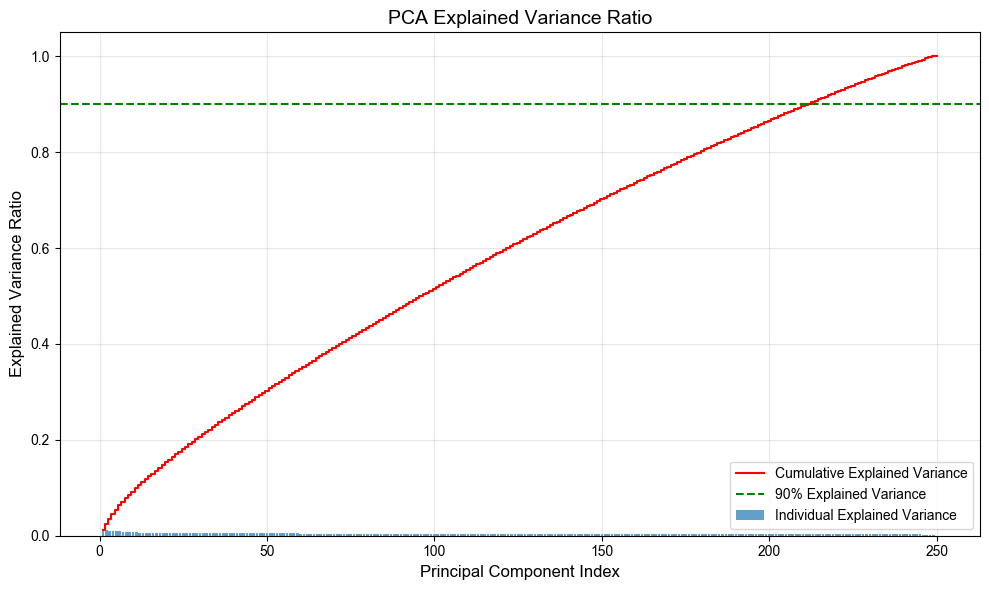

Cumulative explained variance ratio for 250 components: 1.0000


In [57]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- Step 1: Standardization ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 2: PCA ---
n_components_pca = min(X.shape[1], 250)  # 限制主成分數量
pca = PCA(n_components=n_components_pca, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- Step 3: Explained Variance Ratio ---
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# --- Step 4: Plot Explained Variance ---
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid', label='Cumulative Explained Variance', color='red')
plt.axhline(y=0.9, color='green', linestyle='--', label='90% Explained Variance')  # 90% 參考線
plt.xlabel('Principal Component Index', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('PCA Explained Variance Ratio', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Step 5: Print Cumulative Variance ---
print(f"Cumulative explained variance ratio for {n_components_pca} components: {cumulative_variance_ratio[-1]:.4f}")

It can be observed from the plot that the cumulative explained variance ratio only approaches 90% when using more than 200 principal components. This indicates that compressing to fewer than 200 components may result in the loss of significant information, leading to degraded model performance. Therefore, for the features in $X$, compression may not be suitable; retaining the original dimensions is better for ensuring data integrity and model performance.

2. SVD

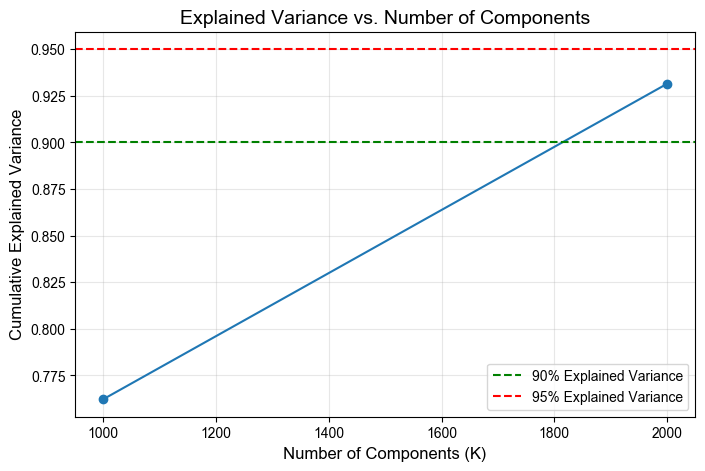

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD

# 設定不同的 K 值範圍
K_values = [1000, 2000]
explained_variances = []

# 計算每個 K 的解釋變異比例
for K in K_values:
    svd = TruncatedSVD(n_components=K, random_state=42)
    svd.fit(Y)
    explained_variances.append(svd.explained_variance_ratio_.sum())

# 繪製解釋變異比例圖
plt.figure(figsize=(8, 5))
plt.plot(K_values, explained_variances, marker='o')
plt.axhline(y=0.9, color='green', linestyle='--', label='90% Explained Variance')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Components (K)', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Explained Variance vs. Number of Components', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

From the plot, it can be seen that when compressed to 1000 components, the cumulative explained variance ratio is approximately 77.5%; when compressed to 2000 components, it reaches approximately 92.5%. This suggests that to achieve an explained variance ratio of 80%, at least 1500 components are required. Therefore, for the features in $Y$, compressing to fewer than 1500 components may result in the loss of important information. It is recommended to choose the compression dimension based on specific needs, bearing in mind that excessive compression may affect model performance.

Set SVD (K=1500) to compress $Y$.

In [73]:
from sklearn.decomposition import TruncatedSVD

# 壓縮 Y 到 1500 維
K = 1500
svd = TruncatedSVD(n_components=K, random_state=42)
svd_y= svd.fit_transform(Y)  # Y -> Z (n_samples × 1500)
V = svd.components_.astype(np.float32, copy=False)
print(f"Explained variance by SVD (K={K}): {svd.explained_variance_ratio_.sum():.3f}")

Explained variance by SVD (K=1500): 0.866


3. Run ElasticNet with Reduced-Dimension $Y$ 

In [ ]:
import numpy as np
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNetCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score

# ---- 0) 数据准备 ----
# 假设你已经有：X (n×250)、Y (n×~3231)、targetX (1×250)、terms_list = list(Y.columns)
Xs = X.to_numpy(dtype=np.float32, copy=False) if hasattr(X, "to_numpy") else np.asarray(X, dtype=np.float32)
Ys = Y.to_numpy(dtype=np.float32, copy=False) if hasattr(Y, "to_numpy") else np.asarray(Y, dtype=np.float32)


# ---- 1) 参数设置 ----
K = 1500  # SVD 压缩维度
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# ElasticNetCV 设置
enet = ElasticNetCV(
    l1_ratio=[0.9, 1.0],   # 以 Lasso 为主
    cv=3,                  # 内部 alpha 的 CV 次数
    n_alphas=30,           # alpha 网格数
    max_iter=3000,
    tol=1e-3,
    n_jobs=-1
)
reg_base = MultiOutputRegressor(enet, n_jobs=-1)

# ---- 2) 交叉验证 ----
scores = []
for tr, te in cv.split(Xs):
    # 2.1) 压缩 Y -> Z
    svd = TruncatedSVD(n_components=K, random_state=42)
    Z_tr = svd.fit_transform(Ys[tr])
    Z_te = svd.transform(Ys[te])

    # 2.2) 标准化 X
    scaler = StandardScaler(with_mean=not is_sparse)
    X_tr = scaler.fit_transform(Xs[tr])
    X_te = scaler.transform(Xs[te])

    # 2.3) X -> Z
    reg = reg_base
    reg.fit(X_tr, Z_tr)

    # 2.4) 回到 terms 空间算 R²（variance-weighted）
    Z_hat = reg.predict(X_te)
    Y_hat = Z_hat @ svd.components_
    scores.append(r2_score(Ys[te], Y_hat, multioutput="variance_weighted"))

print(f"CV R² @ K=1500: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# ---- 3) 用全部数据重训，解码 targetX ----
svd_full = TruncatedSVD(n_components=K, random_state=42)
Z_full = svd_full.fit_transform(Ys)

scaler_full = StandardScaler(with_mean=not is_sparse)
Xs_full = scaler_full.fit_transform(Xs)

reg_full = MultiOutputRegressor(
    ElasticNetCV(l1_ratio=[0.9, 1.0], cv=3, n_alphas=30, max_iter=3000, tol=1e-3, n_jobs=-1),
    n_jobs=-1
).fit(Xs_full, Z_full)

target_s = scaler_full.transform(np.asarray(targetX, dtype=np.float32))
Z_pred = reg_full.predict(target_s)                # (1, K)
pred_terms = Z_pred @ svd_full.components_         # (1, T)

# ---- 4) 输出预测结果 ----
top_k = 10
idx = np.argsort(pred_terms[0])[::-1][:top_k]
print("Top predicted terms (@K=1500, ElasticNetCV):")
for i in idx:
    print(f"{terms_list[i]}: {pred_terms[0][i]:.4f}")

/opt/anaconda3/envs/liwc-nano/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/liwc-nano/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/liwc-nano/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_desc

CV R² @ K=1500: 0.0116 ± 0.0005


/opt/anaconda3/envs/liwc-nano/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/liwc-nano/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/liwc-nano/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_desc

Top predicted terms (@K=1500, ElasticNetCV):
terms_abstract_tfidf__amygdala: 0.1787
terms_abstract_tfidf__emotional: 0.1097
terms_abstract_tfidf__faces: 0.0863
terms_abstract_tfidf__emotion: 0.0711
terms_abstract_tfidf__social: 0.0542
terms_abstract_tfidf__neutral: 0.0520
terms_abstract_tfidf__stimuli: 0.0490
terms_abstract_tfidf__negative: 0.0481
terms_abstract_tfidf__face: 0.0439
terms_abstract_tfidf__fearful: 0.0376


In [ ]:
import numpy as np
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import clone
import warnings
from sklearn.exceptions import ConvergenceWarning

# --- 關閉多餘 warning ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---- 0) 資料準備 ----
Xs = X.to_numpy(dtype=np.float32, copy=False) if hasattr(X, "to_numpy") else np.asarray(X, dtype=np.float32)
Ys = Y.to_numpy(dtype=np.float32, copy=False) if hasattr(Y, "to_numpy") else np.asarray(Y, dtype=np.float32)
is_sparse = sparse.issparse(Xs)

# ---- 1) 參數設定 ----
K = 1500  # SVD 壓縮維度
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 僅 5 個 alpha（對數尺度）
alpha_grid = np.logspace(-3, 1, 5)   # [1e-3, 1e-2, 1e-1, 1e0, 1e1]
l1_grid = [0.9, 1.0]                  # 兩個 l1_ratio（含 Lasso）

print("Alpha grid used:", alpha_grid)
print("l1_ratio grid used:", l1_grid)

enet = ElasticNetCV(
    alphas=alpha_grid,
    l1_ratio=l1_grid,
    cv=3,                 # ElasticNetCV 內部的 alpha CV 次數
    max_iter=3000,
    tol=1e-3,
    n_jobs=-1,
    selection="random"
)
reg_base = MultiOutputRegressor(enet, n_jobs=-1)

# ---- 2) 外層交叉驗證（回報 R² 與 MSE）----
r2_scores, mse_scores = [], []
r2_scores, mse_scores = [], []

for fold_idx, (tr, te) in enumerate(cv.split(Xs), 1):
    # 2.1) 壓縮 Y -> Z
    svd = TruncatedSVD(n_components=K, random_state=42)
    Z_tr = svd.fit_transform(Ys[tr])
    Z_te = svd.transform(Ys[te])

    # 2.2) 標準化 X
    scaler = StandardScaler(with_mean=not is_sparse)
    X_tr = scaler.fit_transform(Xs[tr])
    X_te = scaler.transform(Xs[te])

    # 2.3) X -> Z（每個輸出各自做 ENet CV）
    reg = clone(reg_base)
    reg.fit(X_tr, Z_tr)

    # 2.4) 回到 terms 空間算指標
    Z_hat = reg.predict(X_te)
    Y_hat = Z_hat @ svd.components_

    r2 = r2_score(Ys[te], Y_hat, multioutput="variance_weighted")
    mse = mean_squared_error(Ys[te], Y_hat)  # 多輸出均值（uniform average）
    r2_scores.append(r2)
    mse_scores.append(mse)

    print(f"[CV fold {fold_idx}] R²={r2:.4f}, MSE={mse:.6f}")

print(f"\nCV R² @ K={K}: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"CV MSE @ K={K}: {np.mean(mse_scores):.6f} ± {np.std(mse_scores):.6f}")

# ---- 3) 用全部資料重訓，並彙總 alpha / l1_ratio 的選擇分佈 ----
svd_full = TruncatedSVD(n_components=K, random_state=42)
Z_full = svd_full.fit_transform(Ys)

scaler_full = StandardScaler(with_mean=not is_sparse)
Xs_full = scaler_full.fit_transform(Xs)

reg_full = MultiOutputRegressor(
    ElasticNetCV(alphas=alpha_grid, l1_ratio=l1_grid, cv=3, max_iter=3000, tol=1e-3,
                 n_jobs=-1, selection="random"),
    n_jobs=-1
).fit(Xs_full, Z_full)

# 收集每個輸出選到的 alpha_ / l1_ratio_
chosen_alphas = np.array([est.alpha_ for est in reg_full.estimators_], dtype=float)
chosen_l1s = np.array([est.l1_ratio_ for est in reg_full.estimators_], dtype=float)

# 針對 alpha 做次數統計（最多 5 個，對應我們的 grid）
ua, ca = np.unique(chosen_alphas, return_counts=True)
# 針對 l1_ratio 做次數統計
ul, cl = np.unique(chosen_l1s, return_counts=True)

print("\n=== Summary of selected hyperparameters on full-data fit ===")
print("Alpha grid tried:", alpha_grid)
for a, c in zip(ua, ca):
    print(f"alpha={a:g} -> chosen by {c} outputs")

print("l1_ratio grid tried:", l1_grid)
for l, c in zip(ul, cl):
    print(f"l1_ratio={l} -> chosen by {c} outputs")

# ---- 4) 解碼目標向量，輸出 Top terms ----
target_s = scaler_full.transform(np.asarray(targetX, dtype=np.float32))
Z_pred = reg_full.predict(target_s)                 # (1, K)
pred_terms = Z_pred @ svd_full.components_          # (1, T)

top_k = 10
idx = np.argsort(pred_terms[0])[::-1][:top_k]
print("\nTop predicted terms (@K=1500, ElasticNetCV):")
for i in idx:
    print(f"{terms_list[i]}: {pred_terms[0][i]:.4f}")


Alpha grid used: [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
l1_ratio grid used: [0.9, 1.0]
[CV fold 1] R²=0.0105, MSE=0.000297
[CV fold 2] R²=0.0112, MSE=0.000296


/opt/anaconda3/envs/liwc-nano/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV fold 3] R²=0.0116, MSE=0.000296
[CV fold 4] R²=0.0117, MSE=0.000296
[CV fold 5] R²=0.0107, MSE=0.000297

CV R² @ K=1500: 0.0111 ± 0.0005
CV MSE @ K=1500: 0.000296 ± 0.000000

=== Summary of selected hyperparameters on full-data fit ===
Alpha grid tried: [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
alpha=0.001 -> chosen by 321 outputs
alpha=10 -> chosen by 1179 outputs
l1_ratio grid tried: [0.9, 1.0]
l1_ratio=0.9 -> chosen by 1483 outputs
l1_ratio=1.0 -> chosen by 17 outputs

Top predicted terms (@K=1500, ElasticNetCV):
amygdala: 0.1477
emotional: 0.1046
faces: 0.0846
emotion: 0.0655
social: 0.0491
stimuli: 0.0488
face: 0.0484
neutral: 0.0477
negative: 0.0448
facial: 0.0361



- CV $R^2 \approx 0.011 \pm 0.0005$ ($> 0$, but only slightly better than predicting the mean); the performance across folds is stable $\rightarrow$ no obvious overfitting, but the improvement is minimal. The model is able to capture semantics consistent with the amygdala, but the overall decoding effect is small.

- ElasticNet is capable of "selecting a small number of key features" and stabilizing them using L2 regularization, making it slightly better than Ridge.

##  MLPRegressor

1. X, Y (Full Output Space)


In [82]:
import numpy as np
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

# -------- 0) 準備資料 --------
# X: (n, M) 的 BoVW；Y: (n, T) 是原始術語向量；targetX: (1, M)
X_arr = X.to_numpy(dtype=np.float32, copy=False) if hasattr(X, "to_numpy") else np.asarray(X, dtype=np.float32)
if sparse.issparse(X_arr):
    X_arr = X_arr.toarray()  # MLP 不吃稀疏，轉成 dense

Y_arr = Y.to_numpy(dtype=np.float32, copy=False) if hasattr(Y, "to_numpy") else np.asarray(Y, dtype=np.float32)

# -------- 1) 切分 + 標準化 X --------
X_tr, X_te, Y_tr, Y_te = train_test_split(X_arr, Y_arr, test_size=0.2, random_state=42,shuffle=True)

scaler = StandardScaler()           # X 是 dense，用 with_mean=True
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

# -------- 2) MLP（單一模型，原生多輸出）--------
mlp = MLPRegressor(
    hidden_layer_sizes=(128,),      # 簡單一層
    activation='relu',
    alpha=1e-3,                     # L2
    learning_rate='adaptive',
    learning_rate_init=1e-3,
    max_iter=300,
    early_stopping=True,            # 自動停
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42,
    verbose=False
)

# 訓練（X -> Y）
mlp.fit(X_tr_s, Y_tr)

# Holdout 在 Y 空間的表現
Y_hat = mlp.predict(X_te_s)
r2_y  = r2_score(Y_te, Y_hat, multioutput="variance_weighted")
mse_y = mean_squared_error(Y_te, Y_hat)
print(f"[MLP] Holdout on Y  R^2={r2_y:.4f}  MSE={mse_y:.6f}")

# -------- 3) 用全資料重訓並解碼 targetX --------
X_s_all = scaler.fit_transform(X_arr)
mlp.fit(X_s_all, Y_arr)

targetX_arr = np.asarray(targetX, dtype=np.float32)
if sparse.issparse(targetX_arr):
    targetX_arr = targetX_arr.toarray()
targetX_s = scaler.transform(targetX_arr)

Y_target = mlp.predict(targetX_s)           # (1, T)

# -------- 4) 輸出 top-k 詞 --------
top_k = 10
idx = np.argsort(Y_target[0])[::-1][:top_k]
print("\nTop predicted terms (MLP on Y):")
for i in idx:
    print(f"{terms_list[i]}: {Y_target[0][i]:.4f}")

[MLP] Holdout on Y  R^2=-0.0256  MSE=0.000307

Top predicted terms (MLP on Y):
amygdala: 0.0859
adaptation: 0.0512
risk: 0.0470
social: 0.0427
schizophrenia: 0.0409
image: 0.0399
object: 0.0392
group: 0.0380
self: 0.0369
visual: 0.0367


2. X, svd_y (Reduced Output Space)

In [83]:
import numpy as np
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

# -------- 0) 準備資料 --------
# X: (n, M) 的 BoVW；svd_y: (n, K) 是你用 TruncatedSVD 壓好的 Y；
# V: (K, T) = svd.components_；targetX: (1, M)
X_arr = X.to_numpy(dtype=np.float32, copy=False) if hasattr(X, "to_numpy") else np.asarray(X, dtype=np.float32)
if sparse.issparse(X_arr):
    X_arr = X_arr.toarray()  # MLP 不吃稀疏，轉成 dense

Z_arr = np.asarray(svd_y, dtype=np.float32)       # 壓縮後的目標 (n, K)
V_arr = np.asarray(V, dtype=np.float32)           # 還原矩陣 (K, T)

# -------- 1) 切分 + 標準化 X --------
X_tr, X_te, Z_tr, Z_te = train_test_split(X_arr, Z_arr, test_size=0.2, random_state=42,shuffle=True)

scaler = StandardScaler()           # X 是 dense，用 with_mean=True
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

# -------- 2) MLP（單一模型，原生多輸出）--------
mlp = MLPRegressor(
    hidden_layer_sizes=(128,),      # 簡單一層
    activation='relu',
    alpha=1e-3,                     # L2
    learning_rate='adaptive',
    learning_rate_init=1e-3,
    max_iter=300,
    early_stopping=True,            # 自動停
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42,
    verbose=False
)

# 訓練（X -> Z）
mlp.fit(X_tr_s, Z_tr)

# Holdout 在 Z 空間的表現
Z_hat = mlp.predict(X_te_s)
r2_z  = r2_score(Z_te, Z_hat, multioutput="variance_weighted")
mse_z = mean_squared_error(Z_te, Z_hat)
print(f"[MLP] Holdout on Z  R^2={r2_z:.4f}  MSE={mse_z:.6f}")

# -------- 3) 用全資料重訓並解碼 targetX --------
X_s_all = scaler.fit_transform(X_arr)
mlp.fit(X_s_all, Z_arr)

targetX_arr = np.asarray(targetX, dtype=np.float32)
if sparse.issparse(targetX_arr):
    targetX_arr = targetX_arr.toarray()
targetX_s = scaler.transform(targetX_arr)

Z_target = mlp.predict(targetX_s)           # (1, K)
y_pred   = Z_target @ V_arr                 # (1, T) 還原到 term 空間

# -------- 4) 輸出 top-k 詞 --------
top_k = 10
idx = np.argsort(y_pred[0])[::-1][:top_k]
print("\nTop predicted terms (MLP on svd_y):")
for i in idx:
    print(f"{terms_list[i]}: {y_pred[0][i]:.4f}")


[MLP] Holdout on Z  R^2=-0.0155  MSE=0.000566

Top predicted terms (MLP on svd_y):
amygdala: 0.0895
self: 0.0611
faces: 0.0470
mdd: 0.0467
social: 0.0442
asd: 0.0403
temporal: 0.0396
adhd: 0.0383
schizophrenia: 0.0375
face: 0.0374


Result Comparison:

Evaluation Metrics ($R^2$ and MSE):
- $R^2$ (Variance Weighted): $R^2$ on $Z$: -0.0155 vs $R^2$ on $Y$: -0.0256

    Conclusion: Under the variance-weighted $R^2$ evaluation, the model performs slightly better in the $Z$ space (after SVD compression). An $R^2$ value closer to 0 (or a smaller negative value) indicates that the correlation (or explained variance) between the model's predictions and the true values in the $Z$ space is slightly higher than in the $Y$ space.


- MSE： MSE on Z: 0.000566 vs MSE on Y: 0.000307
   Conclusion: Under the Mean Squared Error evaluation, the model performs slightly better in the $Y$ space (original term space). A smaller MSE value indicates that the prediction error of the model in the $Y$ space is slightly lower than in the $Z$ space.

- Common Terms: Both methods successfully predicted "amygdala".